In [76]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, r2_score, mean_absolute_error

from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD, accuracy
from surprise import KNNBasic

In [77]:
import os
import re

import numpy as np
import pandas as pd
import tables

import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
from gensim.models import FastText

from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import plot_model

# Taste profile dataset

In [79]:
taste_profile_df = pd.read_csv('/home/016651544/DATA-270/datasets/train_triplets.txt', sep='\t', header=None, names = ['user_id','song_id','play_count'], nrows = 2000000)
taste_profile_df.shape


(2000000, 3)

In [80]:
total=taste_profile_df.isnull().sum().sort_values(ascending=False)
percent=(taste_profile_df.isnull().sum()/taste_profile_df.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['total','percent'])
missing_data.head(20)

,total,percent
user_id,0,0.0
song_id,0,0.0
play_count,0,0.0


In [81]:
taste_profile_df.duplicated().sum()

0

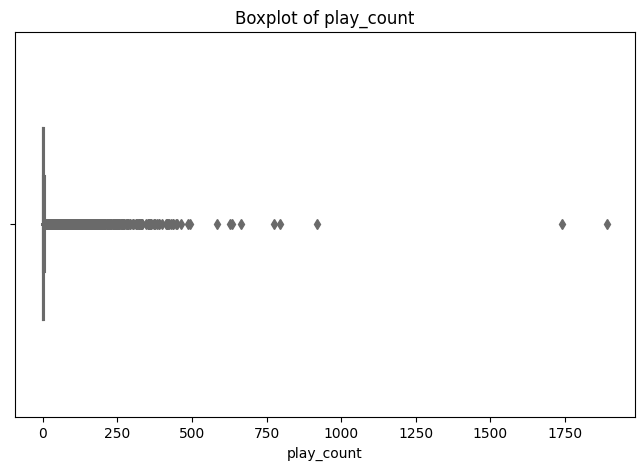

In [82]:
numeric_columns = taste_profile_df.select_dtypes(include=['float64', 'int64'])
for column in numeric_columns.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=numeric_columns[column], palette="Set3", width=0.5)
    plt.title(f"Boxplot of {column}")
    plt.show()

In [83]:
taste_profile_df.head(8)

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBNZDC12A6D4FC103,1
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1


In [84]:
taste_profile_df.dtypes

user_id       object
song_id       object
play_count     int64
dtype: object

In [85]:
taste_profile_df.describe()

,play_count
count,2.000000e+06
mean,2.870298e+00
std,6.292836e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,1.890000e+03


# META DATA

## a) MSD summary 

In [86]:
song_data_df = tables.open_file("/home/016651544/DATA-270/datasets/msd_summary_file.h5", mode="r")
song_data_table = song_data_df.root.metadata.songs
metadata_table_df = pd.DataFrame.from_records(song_data_table[:])
metadata_table_df.shape

(1000000, 20)

In [87]:
metadata_table_df.dtypes

analyzer_version        object
artist_7digitalid        int32
artist_familiarity     float64
artist_hotttnesss      float64
artist_id               object
artist_latitude        float64
artist_location         object
artist_longitude       float64
artist_mbid             object
artist_name             object
artist_playmeid          int32
genre                   object
idx_artist_terms         int32
idx_similar_artists      int32
release                 object
release_7digitalid       int32
song_hotttnesss        float64
song_id                 object
title                   object
track_7digitalid         int32
dtype: object

In [88]:
metadata_table_df.head(4)

,analyzer_version,artist_7digitalid,artist_familiarity,artist_hotttnesss,artist_id,artist_latitude,artist_location,artist_longitude,artist_mbid,artist_name,artist_playmeid,genre,idx_artist_terms,idx_similar_artists,release,release_7digitalid,song_hotttnesss,song_id,title,track_7digitalid
0,b'',4069,0.649822,0.394032,b'ARYZTJS1187B98C555',NaN,b'',NaN,b'357ff05d-848a-44cf-b608-cb34b5701ae5',b'Faster Pussy cat',44895,b'',0,0,b'Monster Ballads X-Mas',633681,0.542899,b'SOQMMHC12AB0180CB8',b'Silent Night',7032331
1,b'',113480,0.439604,0.356992,b'ARMVN3U1187FB3A1EB',NaN,b'',NaN,b'8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9',b'Karkkiautomaatti',-1,b'',0,0,b'Karkuteill\xc3\xa4',145266,0.299877,b'SOVFVAK12A8C1350D9',b'Tanssi vaan',1514808
2,b'',63531,0.643681,0.437504,b'ARGEKB01187FB50750',55.8578,"b'Glasgow, Scotland'",-4.24251,b'3d403d44-36ce-465c-ad43-ae877e65adc4',b'Hudson Mohawke',-1,b'',0,0,b'Butter',625706,0.617871,b'SOGTUKN12AB017F4F1',b'No One Could Ever',6945353
3,b'',65051,0.448501,0.372349,b'ARNWYLR1187B9B2F9C',NaN,b'',NaN,b'12be7648-7094-495f-90e6-df4189d68615',b'Yerba Brava',34000,b'',0,0,b'De Culo',199368,NaN,b'SOBNYVR12A8C13558C',b'Si Vos Quer\xc3\xa9s',2168257


In [89]:
metadata_table_df.head(4).transpose()

,0,1,2,3
analyzer_version,b'',b'',b'',b''
artist_7digitalid,4069,113480,63531,65051
artist_familiarity,0.649822,0.439604,0.643681,0.448501
artist_hotttnesss,0.394032,0.356992,0.437504,0.372349
artist_id,b'ARYZTJS1187B98C555',b'ARMVN3U1187FB3A1EB',b'ARGEKB01187FB50750',b'ARNWYLR1187B9B2F9C'
artist_latitude,NaN,NaN,55.8578,NaN
artist_location,b'',b'',"b'Glasgow, Scotland'",b''
artist_longitude,NaN,NaN,-4.24251,NaN
artist_mbid,b'357ff05d-848a-44cf-b608-cb34b5701ae5',b'8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9',b'3d403d44-36ce-465c-ad43-ae877e65adc4',b'12be7648-7094-495f-90e6-df4189d68615'
artist_name,b'Faster Pussy cat',b'Karkkiautomaatti',b'Hudson Mohawke',b'Yerba Brava'


In [90]:
metadata_table_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
artist_7digitalid,1000000.0,1.256808e+05,1.449954e+05,-1.0000,1.560900e+04,6.282700e+04,1.855990e+05,8.170660e+05
artist_familiarity,999815.0,5.572033e-01,1.386107e-01,0.0000,4.782527e-01,5.589054e-01,6.414201e-01,1.000000e+00
artist_hotttnesss,999988.0,3.798134e-01,1.259604e-01,0.0000,3.363240e-01,3.861945e-01,4.440658e-01,1.082503e+00
artist_latitude,357492.0,3.899942e+01,1.519632e+01,-53.1000,3.407215e+01,4.065507e+01,4.760356e+01,7.069576e+01
artist_longitude,357492.0,-5.837080e+01,5.495556e+01,-162.4365,-9.152382e+01,-7.736692e+01,-2.232180e+00,1.786910e+02
artist_playmeid,1000000.0,2.630221e+04,4.705215e+04,-1.0000,-1.000000e+00,4.800000e+01,3.396400e+04,2.429650e+05
idx_artist_terms,1000000.0,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
idx_similar_artists,1000000.0,0.000000e+00,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
release_7digitalid,1000000.0,3.798848e+05,2.374437e+05,-1.0000,1.796850e+05,3.508530e+05,5.828548e+05,8.236540e+05
song_hotttnesss,581965.0,3.560510e-01,2.344409e-01,0.0000,2.150803e-01,3.775316e-01,5.319846e-01,1.000000e+00


In [91]:
total=metadata_table_df.isnull().sum().sort_values(ascending=False)
percent=(metadata_table_df.isnull().sum()/metadata_table_df.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['total','percent'])
missing_data.head(20)

,total,percent
artist_latitude,642508,0.642508
artist_longitude,642508,0.642508
song_hotttnesss,418035,0.418035
artist_familiarity,185,0.000185
artist_hotttnesss,12,0.000012
analyzer_version,0,0.000000
idx_artist_terms,0,0.000000
title,0,0.000000
song_id,0,0.000000
release_7digitalid,0,0.000000


#### Dropping unnecessary columns, handling missing values from MSD summary dataset

In [92]:
metadata_table_df.drop(columns =['analyzer_version', 'artist_7digitalid','artist_id', 'idx_artist_terms','idx_similar_artists','release_7digitalid','artist_location','artist_longitude','artist_latitude','artist_playmeid','track_7digitalid','artist_mbid'],inplace=True)
metadata_table_df.head().transpose()

,0,1,2,3,4
artist_familiarity,0.649822,0.439604,0.643681,0.448501,0.0
artist_hotttnesss,0.394032,0.356992,0.437504,0.372349,0.0
artist_name,b'Faster Pussy cat',b'Karkkiautomaatti',b'Hudson Mohawke',b'Yerba Brava',b'Der Mystic'
genre,b'',b'',b'',b'',b''
release,b'Monster Ballads X-Mas',b'Karkuteill\xc3\xa4',b'Butter',b'De Culo',b'Rene Ablaze Presents Winter Sessions'
song_hotttnesss,0.542899,0.299877,0.617871,NaN,NaN
song_id,b'SOQMMHC12AB0180CB8',b'SOVFVAK12A8C1350D9',b'SOGTUKN12AB017F4F1',b'SOBNYVR12A8C13558C',b'SOHSBXH12A8C13B0DF'
title,b'Silent Night',b'Tanssi vaan',b'No One Could Ever',b'Si Vos Quer\xc3\xa9s',b'Tangle Of Aspens'


In [93]:
metadata_table_df.replace({b'': np.nan}, inplace=True)

In [94]:
metadata_table_df.head().transpose()

,0,1,2,3,4
artist_familiarity,0.649822,0.439604,0.643681,0.448501,0.0
artist_hotttnesss,0.394032,0.356992,0.437504,0.372349,0.0
artist_name,b'Faster Pussy cat',b'Karkkiautomaatti',b'Hudson Mohawke',b'Yerba Brava',b'Der Mystic'
genre,NaN,NaN,NaN,NaN,NaN
release,b'Monster Ballads X-Mas',b'Karkuteill\xc3\xa4',b'Butter',b'De Culo',b'Rene Ablaze Presents Winter Sessions'
song_hotttnesss,0.542899,0.299877,0.617871,NaN,NaN
song_id,b'SOQMMHC12AB0180CB8',b'SOVFVAK12A8C1350D9',b'SOGTUKN12AB017F4F1',b'SOBNYVR12A8C13558C',b'SOHSBXH12A8C13B0DF'
title,b'Silent Night',b'Tanssi vaan',b'No One Could Ever',b'Si Vos Quer\xc3\xa9s',b'Tangle Of Aspens'


In [95]:
metadata_table_df.dtypes


artist_familiarity    float64
artist_hotttnesss     float64
artist_name            object
genre                 float64
release                object
song_hotttnesss       float64
song_id                object
title                  object
dtype: object

In [96]:
total=metadata_table_df.isnull().sum().sort_values(ascending=False)
percent=(metadata_table_df.isnull().sum()/metadata_table_df.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['total','percent'])
missing_data.head(20)

,total,percent
genre,1000000,1.000000
song_hotttnesss,418035,0.418035
artist_familiarity,185,0.000185
title,15,0.000015
artist_hotttnesss,12,0.000012
artist_name,0,0.000000
release,0,0.000000
song_id,0,0.000000


In [97]:
metadata_table_df.drop(columns =['genre'],inplace=True)

In [98]:
metadata_table_df.head().transpose()

,0,1,2,3,4
artist_familiarity,0.649822,0.439604,0.643681,0.448501,0.0
artist_hotttnesss,0.394032,0.356992,0.437504,0.372349,0.0
artist_name,b'Faster Pussy cat',b'Karkkiautomaatti',b'Hudson Mohawke',b'Yerba Brava',b'Der Mystic'
release,b'Monster Ballads X-Mas',b'Karkuteill\xc3\xa4',b'Butter',b'De Culo',b'Rene Ablaze Presents Winter Sessions'
song_hotttnesss,0.542899,0.299877,0.617871,NaN,NaN
song_id,b'SOQMMHC12AB0180CB8',b'SOVFVAK12A8C1350D9',b'SOGTUKN12AB017F4F1',b'SOBNYVR12A8C13558C',b'SOHSBXH12A8C13B0DF'
title,b'Silent Night',b'Tanssi vaan',b'No One Could Ever',b'Si Vos Quer\xc3\xa9s',b'Tangle Of Aspens'


### Handling inconsistent data

In [99]:
#Handling byte-encoded strings in the DataFrame
metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
metadata_table_df.head(4).transpose()

,0,1,2,3
artist_familiarity,0.649822,0.439604,0.643681,0.448501
artist_hotttnesss,0.394032,0.356992,0.437504,0.372349
artist_name,Faster Pussy cat,Karkkiautomaatti,Hudson Mohawke,Yerba Brava
release,Monster Ballads X-Mas,Karkuteillä,Butter,De Culo
song_hotttnesss,0.542899,0.299877,0.617871,NaN
song_id,SOQMMHC12AB0180CB8,SOVFVAK12A8C1350D9,SOGTUKN12AB017F4F1,SOBNYVR12A8C13558C
title,Silent Night,Tanssi vaan,No One Could Ever,Si Vos Querés


## b) Track metadata

In [100]:
track_metadata = pd.read_csv('/home/016651544/DATA-270/datasets/track_metadata.csv')
track_metadata.shape

(1000000, 14)

In [101]:
track_metadata.dtypes

track_id               object
title                  object
song_id                object
release                object
artist_id              object
artist_mbid            object
artist_name            object
duration              float64
artist_familiarity    float64
artist_hotttnesss     float64
year                    int64
track_7digitalid        int64
shs_perf                int64
shs_work                int64
dtype: object

In [102]:
track_metadata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,1000000.0,2.495008e+02,1.262296e+02,0.31302,1.807408e+02,2.288583e+02,2.899326e+02,3.034906e+03
artist_familiarity,1000000.0,5.569153e-01,1.402066e-01,-1.00000,4.782191e-01,5.588783e-01,6.413916e-01,1.000000e+00
artist_hotttnesss,1000000.0,3.797968e-01,1.260503e-01,-1.00000,3.363212e-01,3.861945e-01,4.440658e-01,1.082503e+00
year,1000000.0,1.030326e+03,9.987450e+02,0.00000,0.000000e+00,1.969000e+03,2.002000e+03,2.011000e+03
track_7digitalid,1000000.0,4.213995e+06,2.640600e+06,-1.00000,1.974300e+06,3.947503e+06,6.469678e+06,9.091277e+06
shs_perf,1000000.0,9.404374e+02,9.168962e+03,-1.00000,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.510820e+05
shs_work,1000000.0,4.801739e+02,5.437859e+03,-938.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.172870e+05


In [103]:
track_metadata.head(4).transpose()

,0,1,2,3
track_id,TRMMMYQ128F932D901,TRMMMKD128F425225D,TRMMMRX128F93187D9,TRMMMCH128F425532C
title,Silent Night,Tanssi vaan,No One Could Ever,Si Vos Querés
song_id,SOQMMHC12AB0180CB8,SOVFVAK12A8C1350D9,SOGTUKN12AB017F4F1,SOBNYVR12A8C13558C
release,Monster Ballads X-Mas,Karkuteillä,Butter,De Culo
artist_id,ARYZTJS1187B98C555,ARMVN3U1187FB3A1EB,ARGEKB01187FB50750,ARNWYLR1187B9B2F9C
artist_mbid,357ff05d-848a-44cf-b608-cb34b5701ae5,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,3d403d44-36ce-465c-ad43-ae877e65adc4,12be7648-7094-495f-90e6-df4189d68615
artist_name,Faster Pussy cat,Karkkiautomaatti,Hudson Mohawke,Yerba Brava
duration,252.05506,156.55138,138.97098,145.05751
artist_familiarity,0.649822,0.439604,0.643681,0.448501
artist_hotttnesss,0.394032,0.356992,0.437504,0.372349


### dropping unnecessary columns

In [104]:
track_metadata.drop(columns =['track_id','title','release', 'artist_id','artist_mbid','artist_name','artist_familiarity','artist_hotttnesss','year', 'track_7digitalid','shs_perf','shs_work'], inplace=True)

In [105]:
track_metadata.head(5)

,song_id,duration
0,SOQMMHC12AB0180CB8,252.05506
1,SOVFVAK12A8C1350D9,156.55138
2,SOGTUKN12AB017F4F1,138.97098
3,SOBNYVR12A8C13558C,145.05751
4,SOHSBXH12A8C13B0DF,514.29832


In [106]:
# include only rows where the 'duration' column values fall within the range of 60 to 480 seconds (inclusive). Rows with durations outside this range are removed from the DataFrame.
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration > 480].index)
track_metadata = track_metadata.drop(track_metadata[track_metadata.duration < 60].index)

<Axes: xlabel='duration'>

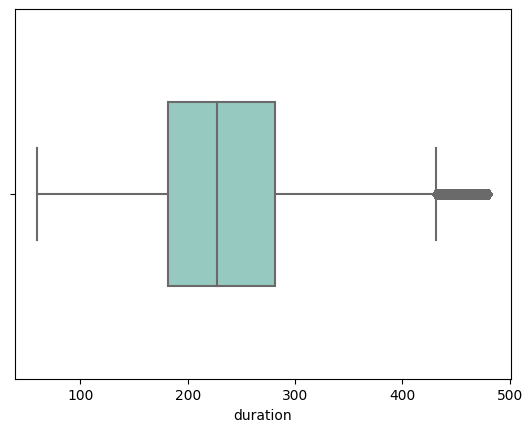

In [107]:
 sns.boxplot(x=track_metadata['duration'], palette="Set3", width=0.5)

In [108]:
track_metadata.shape

(942716, 2)

In [109]:
track_metadata.drop_duplicates(inplace=True)
track_metadata.shape

(942370, 2)

In [110]:
track_metadata.head(8)

,song_id,duration
0,SOQMMHC12AB0180CB8,252.05506
1,SOVFVAK12A8C1350D9,156.55138
2,SOGTUKN12AB017F4F1,138.97098
3,SOBNYVR12A8C13558C,145.05751
6,SOQVRHI12A6D4FB2D7,212.37506
7,SOEYRFT12AB018936C,221.20444
8,SOPMIYT12A6D4F851E,139.17995
9,SOJCFMH12A8C13B0C2,104.48934


### Merging the taste profile and metadata datasets

In [111]:
track_merge = pd.merge(track_metadata, taste_profile_df, on='song_id', how="right")
song_data = pd.merge(metadata_table_df, track_merge, on='song_id', how="right")
song_data.shape

(2128559, 10)

In [114]:
song_data.head()

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration,user_id,play_count
0,0.832012,0.677482,Jack Johnson,Thicker Than Water,0.649006,SOAKIMP12A8C130995,The Cove,112.63955,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,0.580555,0.482492,Billy Preston,To Die For,0.826375,SOAPDEY12A81C210A9,Nothing from Nothing,153.59955,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,0.633119,0.417718,Paco De Lucia,Flamenco Para Niños,0.735295,SOBBMDR12A8C13253B,Entre Dos Aguas,358.24281,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2
3,0.675339,0.509058,Josh Rouse,Under Cold Blue Stars,NaN,SOBFNSP12AF72A0E22,Under Cold Blue Stars,266.34404,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,0.650281,0.451749,The Dead 60s,Nick & Norah's Infinite Playlist - Original Mo...,0.754628,SOBFOVM12A58A7D494,Riot Radio (Soundtrack Version),141.42649,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


In [38]:
song_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2128559 entries, 0 to 2128558
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   artist_familiarity  float64
 1   artist_hotttnesss   float64
 2   artist_name         object 
 3   release             object 
 4   song_hotttnesss     float64
 5   song_id             object 
 6   title               object 
 7   duration            float64
 8   user_id             object 
 9   play_count          int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 178.6+ MB


In [39]:
song_data.describe()

,artist_familiarity,artist_hotttnesss,song_hotttnesss,duration,play_count
count,2.128553e+06,2.128559e+06,1.828431e+06,2.066958e+06,2.128559e+06
mean,7.360061e-01,5.536957e-01,6.887938e-01,2.403702e+02,2.858625e+00
std,1.320956e-01,1.490533e-01,1.973734e-01,6.694649e+01,6.209267e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,6.000281e+01,1.000000e+00
25%,6.511432e-01,4.576263e-01,5.889222e-01,1.991310e+02,1.000000e+00
50%,7.608333e-01,5.367150e-01,7.128672e-01,2.330640e+02,1.000000e+00
75%,8.379479e-01,6.107315e-01,8.214183e-01,2.727440e+02,3.000000e+00
max,1.000000e+00,1.082503e+00,1.000000e+00,4.799995e+02,1.890000e+03


In [40]:
total=song_data.isnull().sum().sort_values(ascending=False)
percent=(song_data.isnull().sum()/song_data.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['total','percent'])
missing_data.head(20)

,total,percent
song_hotttnesss,300128,0.141001
duration,61601,0.028940
artist_familiarity,6,0.000003
title,5,0.000002
artist_hotttnesss,0,0.000000
artist_name,0,0.000000
release,0,0.000000
song_id,0,0.000000
user_id,0,0.000000
play_count,0,0.000000


In [41]:
song_data = song_data.dropna()

In [42]:
total=song_data.isnull().sum().sort_values(ascending=False)
percent=(song_data.isnull().sum()/song_data.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['total','percent'])
missing_data.head(20)

,total,percent
artist_familiarity,0,0.0
artist_hotttnesss,0,0.0
artist_name,0,0.0
release,0,0.0
song_hotttnesss,0,0.0
song_id,0,0.0
title,0,0.0
duration,0,0.0
user_id,0,0.0
play_count,0,0.0


In [43]:
song_data.duplicated().sum()

658

In [44]:
#Remove rows with missing values and duplicate rows of merged dataset.
song_data.drop_duplicates(inplace=True)
song_data.shape

(1776948, 10)

In [45]:
song_data.duplicated().sum()

0

In [46]:
print("Columns and the datatypes in the data: \n", song_data.dtypes)
print("\n\nSummary of column statistics: \n", song_data.describe())


Columns and the datatypes in the data: 
 artist_familiarity    float64
artist_hotttnesss     float64
artist_name            object
release                object
song_hotttnesss       float64
song_id                object
title                  object
duration              float64
user_id                object
play_count              int64
dtype: object


Summary of column statistics: 
        artist_familiarity  artist_hotttnesss  song_hotttnesss      duration  \
count        1.776948e+06       1.776948e+06     1.776948e+06  1.776948e+06   
mean         7.422984e-01       5.570766e-01     6.906530e-01  2.393463e+02   
std          1.247892e-01       1.398934e-01     1.953554e-01  6.601397e+01   
min          0.000000e+00       0.000000e+00     0.000000e+00  6.002893e+01   
25%          6.639805e-01       4.646150e-01     5.911614e-01  1.990526e+02   
50%          7.653570e-01       5.400078e-01     7.146505e-01  2.320975e+02   
75%          8.384095e-01       6.118629e-01     8.222856e

In [47]:
song_data.describe()

,artist_familiarity,artist_hotttnesss,song_hotttnesss,duration,play_count
count,1.776948e+06,1.776948e+06,1.776948e+06,1.776948e+06,1.776948e+06
mean,7.422984e-01,5.570766e-01,6.906530e-01,2.393463e+02,2.838900e+00
std,1.247892e-01,1.398934e-01,1.953554e-01,6.601397e+01,6.206233e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,6.002893e+01,1.000000e+00
25%,6.639805e-01,4.646150e-01,5.911614e-01,1.990526e+02,1.000000e+00
50%,7.653570e-01,5.400078e-01,7.146505e-01,2.320975e+02,1.000000e+00
75%,8.384095e-01,6.118629e-01,8.222856e-01,2.713073e+02,3.000000e+00
max,1.000000e+00,1.082503e+00,1.000000e+00,4.799473e+02,1.890000e+03


In [48]:
numeric_columns = song_data.select_dtypes(include=['float64', 'int64'])


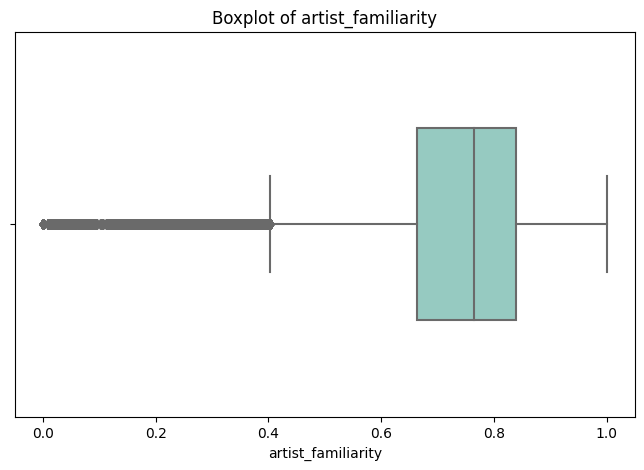

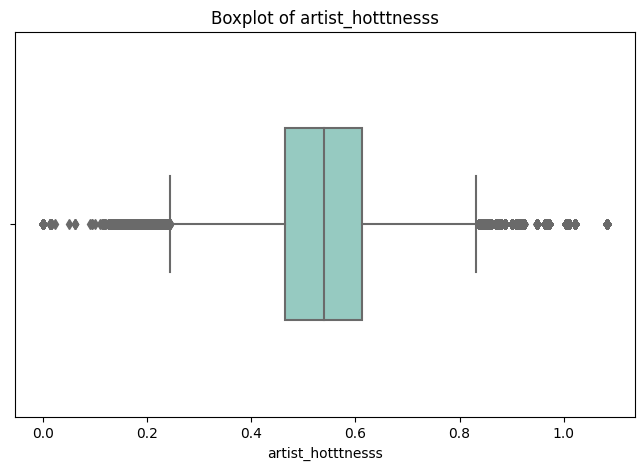

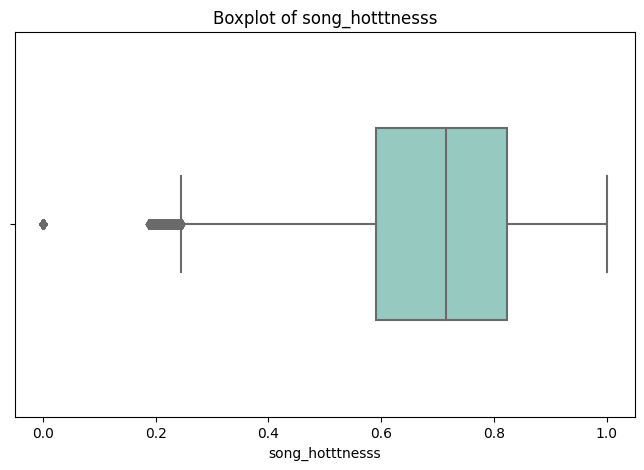

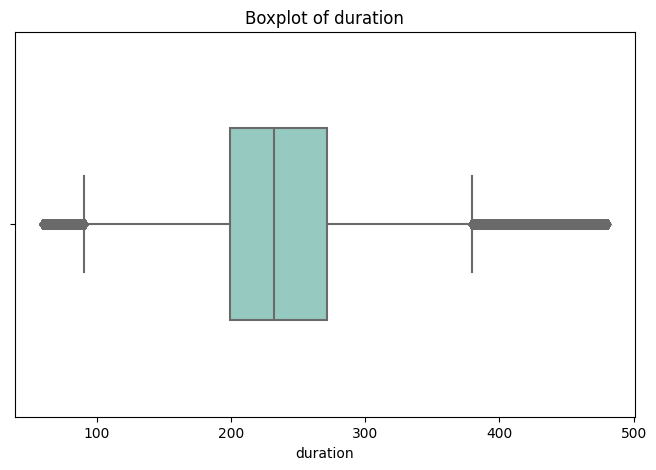

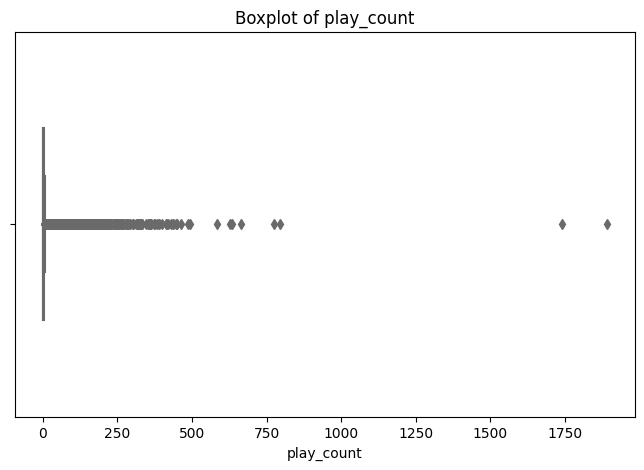

In [49]:
for column in numeric_columns.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=numeric_columns[column], palette="Set3", width=0.5)
    plt.title(f"Boxplot of {column}")
    plt.show()

### Removing outliers

In [50]:
def remove_outliers(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    df = df[(df[column_name] >= lower) & (df[column_name] <= upper)]
    return df

song_data = remove_outliers(song_data, 'play_count')
song_data = remove_outliers(song_data, 'artist_familiarity')
song_data = remove_outliers(song_data, 'artist_hotttnesss')
song_data = remove_outliers(song_data, 'song_hotttnesss')
song_data = remove_outliers(song_data, 'duration')
song_data.shape

(1428056, 10)

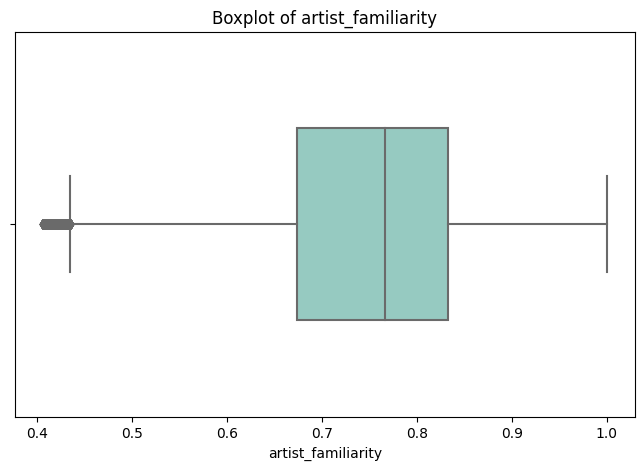

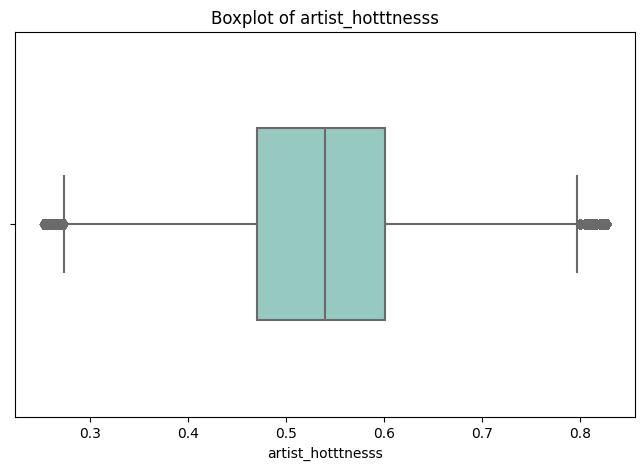

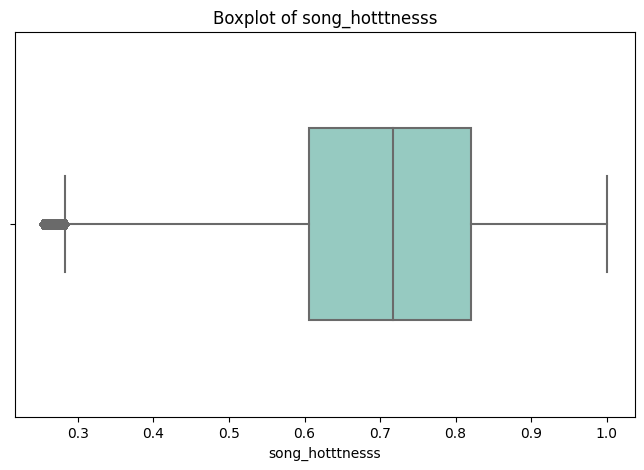

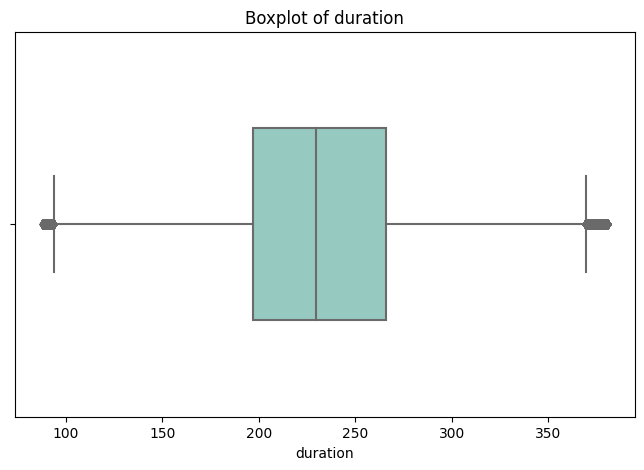

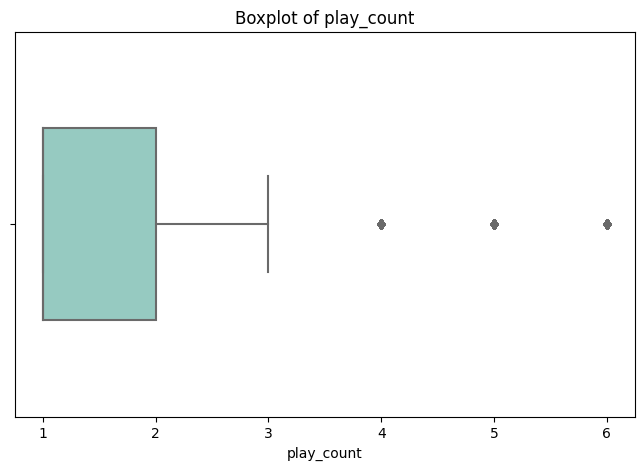

In [51]:
numeric_columns = song_data.select_dtypes(include=['float64', 'int64'])
for column in numeric_columns.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=numeric_columns[column], palette="Set3", width=0.5)
    plt.title(f"Boxplot of {column}")
    plt.show()

In [52]:
song_data = song_data.reset_index(drop=True)
song_data.head(5).transpose()

,0,1,2,3,4
artist_familiarity,0.832012,0.580555,0.633119,0.650281,0.576127
artist_hotttnesss,0.677482,0.482492,0.417718,0.451749,0.436974
artist_name,Jack Johnson,Billy Preston,Paco De Lucia,The Dead 60s,Amset
release,Thicker Than Water,To Die For,Flamenco Para Niños,Nick & Norah's Infinite Playlist - Original Mo...,Amset
song_hotttnesss,0.649006,0.826375,0.735295,0.754628,0.454193
song_id,SOAKIMP12A8C130995,SOAPDEY12A81C210A9,SOBBMDR12A8C13253B,SOBFOVM12A58A7D494,SOBNZDC12A6D4FC103
title,The Cove,Nothing from Nothing,Entre Dos Aguas,Riot Radio (Soundtrack Version),Sin límites (I)
duration,112.63955,153.59955,358.24281,141.42649,190.53669
user_id,b80344d063b5ccb3212f76538f3d9e43d87dca9e,b80344d063b5ccb3212f76538f3d9e43d87dca9e,b80344d063b5ccb3212f76538f3d9e43d87dca9e,b80344d063b5ccb3212f76538f3d9e43d87dca9e,b80344d063b5ccb3212f76538f3d9e43d87dca9e
play_count,1,1,2,1,1


In [53]:
song_data.shape

(1428056, 10)

# Lyrics data

In [54]:
mxm_matches = pd.read_csv(r"/home/016651544/DATA-270/datasets/mxm_779k_matches.csv")
mxm_matches.shape

(779056, 6)

In [55]:
mxm_matches.head()

,track_id,artist name,titleMSD,mxm_track_id,artist_name,titleMXM
0,TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan,4418550,Karkkiautomaatti,Tanssi vaan
1,TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever,8898149,Hudson Mohawke,No One Could Ever
2,TRMMMCH128F425532C,Yerba Brava,Si Vos Querés,9239868,Yerba Brava,Si vos queres
3,TRMMMXN128F42936A5,David Montgomery,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",5346741,Franz Berwald,"Symphony No. 1 in G minor ""Sinfonie Sérieuse"":..."
4,TRMMMBB12903CB7D21,Kris Kross,2 Da Beat Ch'yall,2511405,Kris Kross,2 Da Beat Ch'yall


In [56]:
mxm_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779056 entries, 0 to 779055
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   track_id      779056 non-null  object
 1   artist name   779056 non-null  object
 2   titleMSD      779041 non-null  object
 3   mxm_track_id  779056 non-null  int64 
 4   artist_name   779048 non-null  object
 5   titleMXM      779056 non-null  object
dtypes: int64(1), object(5)
memory usage: 35.7+ MB


In [57]:
mxm_matches.describe()

,mxm_track_id
count,7.790560e+05
mean,4.983914e+06
std,3.133398e+06
min,5.558210e+05
25%,2.194869e+06
50%,4.697886e+06
75%,7.399583e+06
max,1.390010e+07


In [58]:
total=mxm_matches.isnull().sum().sort_values(ascending=False)
percent=(mxm_matches.isnull().sum()/mxm_matches.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['total','percent'])
missing_data.head(20)

,total,percent
titleMSD,15,0.000019
artist_name,8,0.000010
track_id,0,0.000000
artist name,0,0.000000
mxm_track_id,0,0.000000
titleMXM,0,0.000000


In [59]:
mxm_matches=mxm_matches.dropna()

In [60]:
mxm_matches.shape

(779033, 6)

In [61]:
total=mxm_matches.isnull().sum().sort_values(ascending=False)
percent=(mxm_matches.isnull().sum()/mxm_matches.isnull().count()).sort_values(ascending=False)
missing_data=pd.concat([total, percent], axis=1, keys=['total','percent'])
missing_data.head(20)

,total,percent
track_id,0,0.0
artist name,0,0.0
titleMSD,0,0.0
mxm_track_id,0,0.0
artist_name,0,0.0
titleMXM,0,0.0


In [62]:
mxm_matches.duplicated().sum()

0

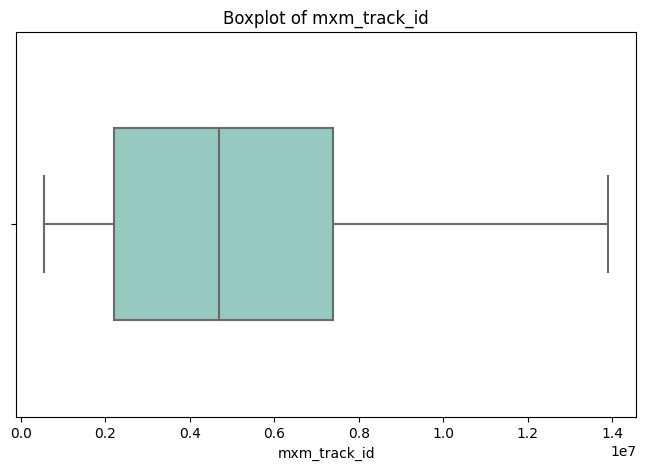

In [63]:
numeric_columns = mxm_matches.select_dtypes(include=['float64', 'int64'])
for column in numeric_columns.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=numeric_columns[column], palette="Set3", width=0.5)
    plt.title(f"Boxplot of {column}")
    plt.show()

In [64]:
lyrics_train = pd.read_csv(r'/home/016651544/DATA-270/datasets/mxm_dataset_train.csv')
lyrics_test = pd.read_csv(r'/home/016651544/DATA-270/datasets/mxm_dataset_test.csv')
display(lyrics_train.head())
display(lyrics_test.head())
print(lyrics_train.shape)
print(lyrics_test.shape)

,track_id,mxm_track_id,word_count
0,TRAAAAV128F421A322,4623710,"{'i': 6, 'the': 4, 'you': 2, 'to': 2, 'and': 5..."
1,TRAAABD128F429CF47,6477168,"{'i': 10, 'you': 17, 'to': 8, 'and': 2, 'a': 2..."
2,TRAAAED128E0783FAB,2516445,"{'i': 28, 'the': 15, 'you': 2, 'to': 12, 'and'..."
3,TRAAAEF128F4273421,3759847,"{'i': 5, 'the': 4, 'you': 3, 'to': 2, 'and': 1..."
4,TRAAAEW128F42930C0,3783760,"{'i': 4, 'to': 5, 'and': 7, 'a': 2, 'me': 4, '..."


,track_id,mxm_track_id,word_count
0,TRAABRX12903CC4816,1548880,"{'the': 19, 'to': 7, 'and': 6, 'in': 1, 'is': ..."
1,TRAADFO128F92E1E91,5325944,"{'i': 79, 'the': 66, 'you': 15, 'to': 7, 'and'..."
2,TRAADQW128F427CE68,3811449,"{'i': 3, 'the': 3, 'you': 2, 'me': 4, 'it': 1,..."
3,TRAADRX12903D0EFE8,5583484,"{'i': 1, 'a': 5, 'me': 1, 'in': 1, 'come': 1, ..."
4,TRAAEJQ128F92C484E,9124657,"{'i': 28, 'the': 7, 'you': 12, 'to': 3, 'and':..."


(210519, 3)
(27143, 3)


In [65]:
song_data.head()

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration,user_id,play_count
0,0.832012,0.677482,Jack Johnson,Thicker Than Water,0.649006,SOAKIMP12A8C130995,The Cove,112.63955,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,0.580555,0.482492,Billy Preston,To Die For,0.826375,SOAPDEY12A81C210A9,Nothing from Nothing,153.59955,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,0.633119,0.417718,Paco De Lucia,Flamenco Para Niños,0.735295,SOBBMDR12A8C13253B,Entre Dos Aguas,358.24281,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2
3,0.650281,0.451749,The Dead 60s,Nick & Norah's Infinite Playlist - Original Mo...,0.754628,SOBFOVM12A58A7D494,Riot Radio (Soundtrack Version),141.42649,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,0.576127,0.436974,Amset,Amset,0.454193,SOBNZDC12A6D4FC103,Sin límites (I),190.53669,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


# Dividing the datasets 

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming song_data is your DataFrame

# Step 1: Split the data into training (70%) and temp (30%)
train_data, temp_data = train_test_split(song_data, test_size=0.3, random_state=42)

# Step 2: Split the temp data into validation (50% of the original size) and test (50% of the original size)
validate_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Step 3: Calculate the percentage of division
total_size = len(song_data)
train_percentage = (len(train_data) / total_size) * 100
validate_percentage = (len(validate_data) / total_size) * 100
test_percentage = (len(test_data) / total_size) * 100

# Step 4: Display the sizes and percentages of each set
print("Train set size:", train_data.shape, f"({train_percentage:.2f}%)")
print("Validation set size:", validate_data.shape, f"({validate_percentage:.2f}%)")
print("Test set size:", test_data.shape, f"({test_percentage:.2f}%)")


Train set size: (999639, 10) (70.00%)
Validation set size: (214208, 10) (15.00%)
Test set size: (214209, 10) (15.00%)


In [67]:
# Assuming train_data, validate_data, and test_data are your prepared DataFrames

# Display a few samples from the training set
print("Training Set of Song Data:")
print(train_data.head())

# Display a few samples from the validation set
print("\nValidation Set of Song Data:")
print(validate_data.head())

# Display a few samples from the test set
print("\nTest Set of Song Data:")
print(test_data.head())


Training Set of Song Data:
         artist_familiarity  artist_hotttnesss                    artist_name  \
846829             0.509463           0.369543  Bill Medley & Jennifer Warnes   
239155             0.713946           0.466991                            Múm   
1336591            0.789104           0.576197            Stone Temple Pilots   
586986             0.816597           0.577076                 Arctic Monkeys   
688171             0.553129           0.425418                Pescado Rabioso   

                                          release  song_hotttnesss  \
846829                              Dirty Dancing         0.788601   
239155                 Go Go Smear The Poison Ivy         0.821042   
1336591                                 Thank You         0.400040   
586986                  Favourite Worst Nightmare         0.961333   
688171   Obras Cumbres Pescado Rabioso/ Invisible         0.596112   

                    song_id                              title   

In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999639 entries, 846829 to 121958
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   artist_familiarity  999639 non-null  float64
 1   artist_hotttnesss   999639 non-null  float64
 2   artist_name         999639 non-null  object 
 3   release             999639 non-null  object 
 4   song_hotttnesss     999639 non-null  float64
 5   song_id             999639 non-null  object 
 6   title               999639 non-null  object 
 7   duration            999639 non-null  float64
 8   user_id             999639 non-null  object 
 9   play_count          999639 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 83.9+ MB


In [69]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214209 entries, 925770 to 20989
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   artist_familiarity  214209 non-null  float64
 1   artist_hotttnesss   214209 non-null  float64
 2   artist_name         214209 non-null  object 
 3   release             214209 non-null  object 
 4   song_hotttnesss     214209 non-null  float64
 5   song_id             214209 non-null  object 
 6   title               214209 non-null  object 
 7   duration            214209 non-null  float64
 8   user_id             214209 non-null  object 
 9   play_count          214209 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 18.0+ MB


In [70]:
validate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214208 entries, 392524 to 159173
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   artist_familiarity  214208 non-null  float64
 1   artist_hotttnesss   214208 non-null  float64
 2   artist_name         214208 non-null  object 
 3   release             214208 non-null  object 
 4   song_hotttnesss     214208 non-null  float64
 5   song_id             214208 non-null  object 
 6   title               214208 non-null  object 
 7   duration            214208 non-null  float64
 8   user_id             214208 non-null  object 
 9   play_count          214208 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 18.0+ MB


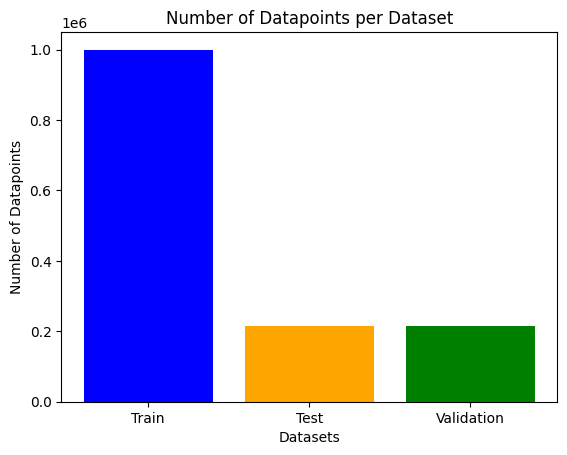

In [71]:
import matplotlib.pyplot as plt

# Assuming you have variables like these with the number of datapoints in each dataset
train_data_points = 999639
test_data_points = 214209
validation_data_points = 214208

# Data
datasets = ['Train', 'Test', 'Validation']
datapoints = [train_data_points, test_data_points, validation_data_points]

# Plotting the bar graph
plt.bar(datasets, datapoints, color=['blue', 'orange', 'green'])
plt.xlabel('Datasets')
plt.ylabel('Number of Datapoints')
plt.title('Number of Datapoints per Dataset')
plt.show()


In [72]:
test_data.head()

,artist_familiarity,artist_hotttnesss,artist_name,release,song_hotttnesss,song_id,title,duration,user_id,play_count
925770,0.790923,0.601185,Boyz II Men,The Best Of Boyz II Men 20th Century Masters T...,0.823972,SOYCXBA12A6701E35B,I'll Make Love To You,235.80689,12817831c40ff5a1c0f59db824d0a138d9a0fbfd,1
327365,0.669846,0.577315,Animal Collective,An Taobh Tuathail Vol III,0.725534,SOMDNXV12A8C130B0B,Loch Raven,299.07546,36770e5a84b443247e667b52330c9ef6c748a6f7,2
918531,0.744410,0.792048,OneRepublic,Waking Up,1.000000,SONYKOW12AB01849C9,Secrets,224.67873,f7e6b560a24c7773b16469f117f554364c9dd9ca,3
341555,0.680850,0.501316,Joan Jett & The Blackhearts,Up Your Alley,0.658300,SORQVAG12A8C13109B,I Hate Myself For Loving You,248.78975,3369f4ac8fe172d1e57a174aaf45613cf8f25323,1
1021566,0.947328,0.607257,Britney Spears,The Singles Collection,0.722956,SODUGQV12AF72A6803,(You Drive Me) Crazy (The Stop Remix!),197.09342,4f3d8337605235071a8b5f035a8859bc5e5873d1,1


### Dividing lyric dataset mxm779k dataset

In [73]:
# Split the dataset into train, validation, and test sets
train_data, temp_data = train_test_split(mxm_matches, test_size=0.3, random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Display the shapes of the resulting datasets
print("Training set shape of Lyric Dataset:", train_data.shape)
print("Validation set shape of Lyric Dataset:", valid_data.shape)
print("Test set shape of Lyric Dataset:", test_data.shape)

# Calculate the percentage split
total_samples = len(mxm_matches)
train_percentage = len(train_data) / total_samples * 100
valid_percentage = len(valid_data) / total_samples * 100
test_percentage = len(test_data) / total_samples * 100

# Display the percentage split
print(f"\nPercentage of Train Dataset: {train_percentage:.2f}%")
print(f"Percentage of Validation Dataset: {valid_percentage:.2f}%")
print(f"Percentage of Test Dataset: {test_percentage:.2f}%")


Training set shape of Lyric Dataset: (545323, 6)
Validation set shape of Lyric Dataset: (116855, 6)
Test set shape of Lyric Dataset: (116855, 6)

Percentage of Train Dataset: 70.00%
Percentage of Validation Dataset: 15.00%
Percentage of Test Dataset: 15.00%


In [74]:
test_data.head(10)

,track_id,artist name,titleMSD,mxm_track_id,artist_name,titleMXM
273583,TRZHMBQ128F4252294,Dimmu Borgir,A succubus in rapture,2058753,Dimmu Borgir,A Succubus in Rapture
561597,TRJJYWY128F92F902D,Jeff Rona,Wonderful Friend,6403340,Jeff Rona,Wonderful Friend
707901,TRXLGUH128F92C614D,Rush Of Fools,Escape,7756436,Rush of Fools,Escape
291010,TRZJGIK128F427E838,Son House,Motherless Children,4956021,Son House,Motherless Children
681443,TROSHWH12903CEE86B,Seamus Egan,Along The Way,634291,Seamus Egan,Along the Way
443490,TRTVRJH128F9343BB3,R.L. Burnside,Walkin' Blues,782268,R.L. Burnside,Walkin' Blues
772390,TRYVRFO128F933A026,Wall Of Voodoo,Chains Of Luck,1792479,Wall of Voodoo,Chains of Luck
702638,TRXANAP128F930A1E6,Kinnie Starr,Alright (Hybrid Vocal Mix),2896556,Kinnie Starr,Alright (Blackwatch vocal club mix)
599607,TRVMWQW128F9323721,Tony Bellus,Robbin' The Cradle,6938892,Tony Bellus,Robbin' the Cradle
766418,TRYTOXE128F424D5AF,Chet Atkins,Third Man Theme,4397882,Chet Atkins,Third Man Theme


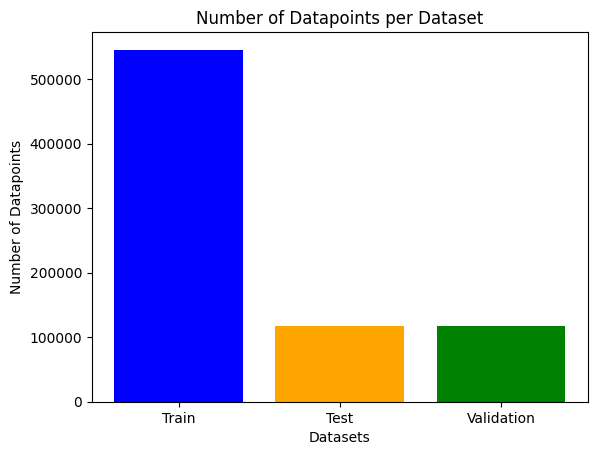

In [75]:
import matplotlib.pyplot as plt

# Assuming you have variables like these with the number of datapoints in each dataset
train_data_points = 545323
test_data_points = 116855
validation_data_points = 116855

# Data
datasets = ['Train', 'Test', 'Validation']
datapoints = [train_data_points, test_data_points, validation_data_points]

# Plotting the bar graph
plt.bar(datasets, datapoints, color=['blue', 'orange', 'green'])
plt.xlabel('Datasets')
plt.ylabel('Number of Datapoints')
plt.title('Number of Datapoints per Dataset')
plt.show()